### Introduction

In this tutorial, we will compare the access, size and performance of the `.SAFE` Sentinel-2 L2A Items available at the [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/) (CDSE) vs. the `.zarr` products directly from the [EOPF Sentinel Zarr Sample Service STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en).

### What we will learn

- 💻 Programmatic access of `.zarr` access through the STAC Catalog
- 💻 Programmatic access of `.SAFE` access through the CDSE
- 🪞 Access to interest assets inside both formats
- 💾 Access to the equivalent metadata of both formats

### Prerequisites

We recommend revising the [STAC Catalog chapter](33_eopf_stac_connection.ipynb), as it gives you an introduction on how to access a STAC catalog programmatically with python.

As we will be using the traditional `.SAFE` format for comparison, you will need to create a user account inside the [CDSE](https://dataspace.copernicus.eu/). If you have not yet registered, you can create an account [here](https://identity.dataspace.copernicus.eu/auth/realms/CDSE/login-actions/registration?execution=10f09889-a37b-4bbf-90c9-b833b16ddb55&client_id=account-console&tab_id=KPrlB_gk1KE). <br>

To register in the platform and learn about all the data you can access, follow [this tutorial](https://documentation.dataspace.copernicus.eu/Registration.html).<br>
This registration will allow you to generate tokens that will be needed to access and download the Sentinel data sets we are interested in.

#### Item of Interest

To compare the equivalent `.zarr` Item to the traditional `.SAFE` item, we will focus on the Alps area of Innsbruck, Austria.
The items that cover this geographical area of interest for this tutorial are noted with the id:

- `S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924`

It is important to point out that until the current re-engineering, one `.SAFE` item equals one `.zarr` item, meaning they cover the same extent and bounding box.

In the future, ESA is looking forward to developing an entire data set dedicated to **zarr**, and a new general format will be unified. These efforts are under current development.

To follow the ongoing discussion, visit the [CDSE Forum](https://forum.dataspace.copernicus.eu/) for the latest updates.


<hr>

#### Import libraries

In [1]:
import requests
import os
import numpy as np
import time
import zipfile
import matplotlib.pyplot as plt
from pystac import Collection, MediaType
from pystac_client import Client, CollectionClient
import xarray as xr
import xml.etree.ElementTree as ET
import matplotlib.image as mpimg
from pympler import asizeof
import pandas as pd

#### Helper functions

##### `get_access_token()`

The CDSE provides a tutorial on how to download via API, Items of interest for the Sentinel missions through the **OpenData Protocol** (OData).
To utilise your CDSE credentials and generate the tokens for your retrieval, this function will help us generate the needed tokens.

In [2]:
def get_access_token(username: str, password: str) -> str:
    data = {
        "client_id": "cdse-public", 
        "username": username, #input credentials
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post( # constructing the request
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Reponse from the server was: {r.json()}"
        )
    return r.json()["access_token"]

##### `get_size()`

This function, allows us to calculate the loaded bytes from the `.zarr` objects we are calling from the cloud.

The returned value is defined in MB

In [3]:
def get_size(element):

    in_bytes = element.nbytes
    if in_bytes > (1024**2):
     size = (in_bytes) / (1024**2)
    return size

<hr>

## Connection to the CDSE

Once an account is created, we are able to provide the designed credentials that will allow us to search and download the files of interest directly to our local machine.

In [4]:
user_name = input("Enter your CDS username (email): ") 
def_pass = input("Enter your CDS password: ")


As we are willing to compare performance response, we will consider the running time for each of the core steps of data access. The time measured is set after we have already provided our credentials and defined until the data is accesed in our working space.

We provide the URL from the Item we are interested in (Sentinel-2 L2A mission) and create our API request.


In [5]:
st= time.time()   # Starts calculating the access time 
access_token = get_access_token(user_name, def_pass)

# url = f"https://download.dataspace.copernicus.eu/odata/v1/Products(5d369f6c-909e-44f6-8fef-3a8220ba13e1)/$value" # Item of interest with

url = f'https://download.dataspace.copernicus.eu/odata/v1/Products(fa3a0848-1568-4dc4-9ecb-dabecf23bd4b)/$value' ## Second
headers = {"Authorization": f"Bearer {access_token}"}
session = requests.Session()
session.headers.update(headers)
response = session.get(url, headers=headers, stream=True) # storing the requested file


After obtaining a response, we set the parameters to enhance the download of our `.SAFE` structured file into a `.zip` form.

In [6]:
with open("sentinel_2_SAFE.zip", "wb") as file:
    for chunk in response.iter_content(chunk_size=1000000):
        if chunk:
            file.write(chunk)

### .`SAFE` access time

For having an overview of the structure and access of the selected file, we can unzip it and access each of the stored bands with the corresponding metadata of the item.

To rectify, we had accessed the correct file, we check the name of the unzipped object, and it corresponds to:


In [7]:
# #Unzip the archive
with zipfile.ZipFile("sentinel_2_SAFE.zip", "r") as zip_ref:
    zip_ref.extractall(".") #Extract to the current directory

#Find the extracted .SAFE folder in the current directory

safe_input = [f for f in os.listdir(".") if f.endswith(".SAFE")][0]

print(f"Extracted: {safe_input}")

Extracted: S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924.SAFE


The `.SAFE` format, is stored based on Granules, which store the available bands, at different resolutions, quality masks and the complementary metadata that allows for to reconstruction and management of the files through different **GIS** software or programming languages.

To calculate the size of the file, we add up the component sizes. Also, we can already define the total time of `.SAFE` retrieval:

In [8]:
safe_size = sum(os.path.getsize(os.path.join(dp, f)) for dp, dn, filenames in os.walk(safe_input) for f in filenames) / (1024**3)

et = time.time()
safe_download_t = et-st

print('Accessed file: ', safe_input)
print(f"SAFE Directory Size: {safe_size:.3f} GB")
print(f'Running time: {(safe_download_t):.3f} sec')

Accessed file:  S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924.SAFE
SAFE Directory Size: 1.173 GB
Running time: 531.961 sec


## Connection to the EOPF Zarr STAC Catalog

Our first step is to establish a connection to the path where the `.zarr` file is stored inside the EOPF Zarr STAC Catalog. This involves recalling the equivalent item stored in the CDSE through the STAC Catalog. As for the latest releases, one `.SAFE` object, is equivalent to one `.zarr` object, and by recalling the same id, we can find the equivalent file inside STAC Catalog:

In [9]:
st = time.time()

item_id = 'S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924'
client = Client.open("https://stac.core.eopf.eodc.eu/")
collection = client.get_collection(collection_id="sentinel-2-l2a")
item = collection.get_item(
    id= item_id
)

print('Retrieved :',item_id,'.zarr')

Retrieved : S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924 .zarr


Once we receive a response, we can proceed to access the storage `URL` embedded inside the assets that compose the item inside the **STAC Catalog**. This reference provides the location of the bucket where our `.zarr` of interest is stored.

Then, we calculate that the access time to connect to the **STAC Catalog** and find the item of interest is:

In [10]:
for asset_name, asset in sorted(
    item.get_assets(media_type=MediaType.ZARR).items(), key=lambda item: item[1].href
):
    roles = asset.roles or []
    # Identify the top-level Zarr group asset. This is what we will access with xarray.
    if "data" in roles and "metadata" in roles:
        stac_object = asset

zarr_url = stac_object.href



zarr_access_t = et-st

print(f'Accessing time: {(zarr_access_t):.3f} sec')

Accessing time: -0.004 sec


In [11]:
# stac_url = 'https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202505-s02msil2a/30/products/cpm_v256/S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924.zarr'

### `.zarr` access time

After obtaining the storage location, we can then access the `DataTree` that will allow us to call the assets inside the `.zarr` that we are interested to explore.

In [12]:
zarr_input = xr.open_datatree(
    zarr_url, engine="zarr") # the retrieved url and the zarr engine.

et = time.time()

zarr_file_t = et-st
print(f'Opening time: {(zarr_file_t):.3f} sec')

/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2969/1804179650.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  zarr_input = xr.open_datatree(
/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2969/1804179650.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  zarr_input = xr.open_datatree(


Opening time: 3.896 sec


Then, calculating the size and retrieval time results in:

In [13]:
# zarr_size = (fs.du(zarr_store)) / (1024**3)
# zarr_size = zarr_input.nbytes / (1024**3)


## Accessing Data

Now that we have connected through the respective spaces and accessed the equivalent data set, we can compare the retrieval procedure and time for assets of interest.

An interesting example is having an overview of the **T**rue **C**olor **I**mage (`tci`) at 60m resolution.

Both for .`SAFE` and `.zarr`, the access procedure can be described as it follows.

### `.SAFE` QuickLook

In the case of .SAFE, the `tci` can be located through the `manifest.safe` file. <br>
The retrieval then, includes the construction of the path location and once found, it can be also called and plotted from the `.jp2` format.

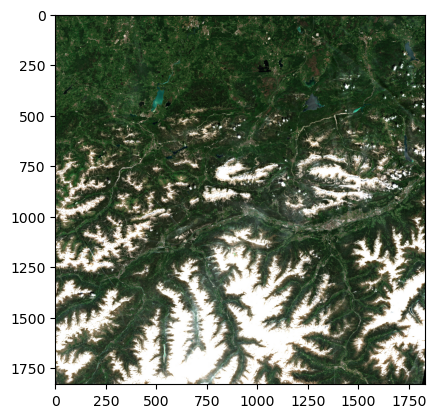

Running time: 0.477 sec
File Size: 3.57 MB


In [36]:
st = time.time()
xml_manifest_path = os.path.join(safe_input,"manifest.safe")
xml_tree = ET.parse(xml_manifest_path)
file_location_element = xml_tree.getroot().find(
    ".//dataObject[@ID='IMG_DATA_Band_TCI_60m_Tile1_Data']/byteStream/fileLocation"
)
assert file_location_element is not None, "failed to find TCI 60m data"
tci_60m_file_path = os.path.join(
    safe_input, file_location_element.get("href")
)
ql_safe = mpimg.imread(tci_60m_file_path)
#ql_safe_60_size =  (asizeof.asizeof(ql_safe))/(1024**2)
ql_safe_size = os.path.getsize(tci_60m_file_path)
# Show data on screen.

plt.imshow(ql_safe)
plt.show()

et = time.time()
safe_ql_t = et-st

print(f'Running time: {(safe_ql_t):.3f} sec')
print(f'File Size: {ql_safe_size /(1024**2):.3} MB')
#print(f'Object Size: {(ql_safe_60_size):.3f} MB')


### `.zarr` QuickLook

The xarray format, allows us to call the group where the `tci` is stored. For the 60m resolution case, it is stored under the `'quality/l2a_quicklook/r60m'` group.

In [21]:
st = time.time()
ql_zarr = zarr_input['quality/l2a_quicklook/r60m'].to_dataset()
print(ql_zarr.info)
ql_zarr = ql_zarr['tci']


<bound method Dataset.info of <xarray.Dataset> Size: 10MB
Dimensions:  (band: 3, y: 1830, x: 1830)
Coordinates:
  * band     (band) int64 24B 1 2 3
  * x        (x) int64 15kB 600030 600090 600150 600210 ... 709650 709710 709770
  * y        (y) int64 15kB 5300010 5299950 5299890 ... 5190390 5190330 5190270
Data variables:
    tci      (band, y, x) uint8 10MB ...>


To access the data, we can select the desired group and its metadata will allow us to reconstruct an overview of the asset, which can be then plotted for a visual explore.

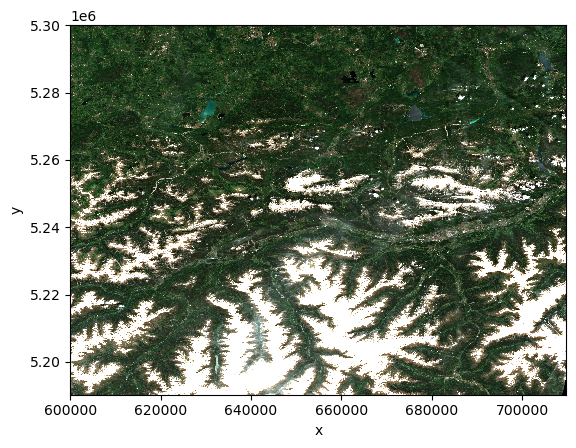

Running time: 4.063 sec
Object  9.581279754638672


In [22]:
ql_zarr.plot.imshow(rgb="band")
plt.show()
et = time.time()

zarr_ql_t = et-st
print(f'Running time: {(zarr_ql_t):.3f} sec')
ql_zarr_size = get_size(ql_zarr)
print('Object ',ql_zarr_size)

## Metadata Access

As every geo-referenced product, `.SAFE` and `.zarr` include essential information about the dataset, such as:

- Satellite Name & Sensor Type
- Processing Level & Projection
- Tile ID and Sensing Time
- Cloud Coverage Information

The way of access the specific information, is described.

### `.SAFE` data

The metadata available for each of the `.SAFE` products is complemented by 2 files that are found inside the store; the `MTD_MSIL2A.xml` and `MTD_TL.xml` files.

To access such files, we can position ourselves inside the `.SAFE` store and get the `.xml` tree structure:

In [23]:
st=time.time()

granule_path = os.path.join(safe_input, "GRANULE")
granules = os.listdir(granule_path)
granule_folder = os.path.join(granule_path, granules[0], "IMG_DATA")

#Retrieves main metadata set
metadata_file = os.path.join(safe_input, "MTD_MSIL2A.xml")

#Restrieves specific metadata from the granules stored in .SAFE
dtree = ET.parse(os.path.join(safe_input, "GRANULE", os.listdir(os.path.join(safe_input, "GRANULE"))[0], "MTD_TL.xml"))

#Acceses the .xml file so we can parse it and search for specific strings.
tree = ET.parse(metadata_file)
root = tree.getroot()
droot = dtree.getroot()

Once the metadata is extracted to a `.xml` `ElementTree`, we can parse it and retrieve the specific information of our interest.

::: Note
Additional libraries like `gdal` allow us to easily retrieve metadata from the items through the `.GetMetadata()` function, but still require the storage of the `.SAFE` product.
:::

The metadata that provides the information of our interest inside the `.xml` files delivers the following information:

In [24]:
safe_metadata = {
    "product_id" :root.findtext(".//PRODUCT_URI"),
    "satellite": root.findtext(".//SPACECRAFT_NAME"),
    "processing_level": root.findtext(".//PROCESSING_LEVEL"),    
    "product_type": root.findtext(".//PRODUCT_TYPE"),
    "instrument": root.findtext(".//DATATAKE_TYPE"),    
    "instrument_mode": root.findtext(".//DATATAKE_TYPE"),
    "epsg": droot.findtext(".//HORIZONTAL_CS_CODE"),
    "date_of_retrieval": root.findtext(".//GENERATION_TIME")[:10],
    "sensing_time": root.findtext(".//PRODUCT_START_TIME")[11:19],
    "cloud_coverage": droot.findtext(".//CLOUDY_PIXEL_OVER_LAND_PERCENTAGE")
}

et = time.time()

safe_meta_t = et-st
print(f'Running time: {(safe_meta_t):.3f} sec')
print(f'Some of the .SAFE selected metadata:')
safe_metadata

Running time: 1.630 sec
Some of the .SAFE selected metadata:


{'product_id': 'S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924.SAFE',
 'satellite': 'Sentinel-2B',
 'processing_level': 'Level-2A',
 'product_type': 'S2MSI2A',
 'instrument': 'INS-NOBS',
 'instrument_mode': 'INS-NOBS',
 'epsg': 'EPSG:32632',
 'date_of_retrieval': '2025-05-30',
 'sensing_time': '10:15:59',
 'cloud_coverage': '3.166546'}

### `.zarr` data

For the `.zarr` case, we can access directly the metadata from the `zarr_input` item through the `.attrs` parameter, indicating the group it belongs to. <br>
The resulting data for this retieval and processing time deliver the following information:

In [25]:
st = time.time()

zarr_metadata = {
    "product_id": zarr_input.attrs["stac_discovery"]["id"],
    "mission_id": zarr_input.attrs["stac_discovery"]["properties"]["platform"],

    "processing_level": zarr_input.attrs["stac_discovery"]["properties"]["processing:level"],
    
    "product_type": zarr_input.attrs["stac_discovery"]["properties"]['product:type'],
    "instrument":zarr_input.attrs["stac_discovery"]["properties"]['instrument'],
    "instrument_mode": zarr_input.attrs["stac_discovery"]["properties"]['eopf:instrument_mode'],
    "epsg": zarr_input.attrs["stac_discovery"]["properties"]['proj:epsg'],

    "processing_time": zarr_input.attrs["stac_discovery"]["properties"]["created"][:10],
    "cloud_cover ": zarr_input.attrs["stac_discovery"]["properties"]["eo:cloud_cover"]
}
et = time.time()

zarr_meta_t = et-st
print(f'Running time: {(zarr_meta_t):.3f} sec')
print(f'Some of the .zarr selected metadata:')
zarr_metadata

Running time: 0.000 sec
Some of the .zarr selected metadata:


{'product_id': 'S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924.SAFE',
 'mission_id': 'sentinel-2b',
 'processing_level': 'L2A',
 'product_type': 'S02MSIL2A',
 'instrument': 'msi',
 'instrument_mode': 'INS-NOBS',
 'epsg': 32632,
 'processing_time': '2025-05-30',
 'cloud_cover ': 3.303884}

## Comparison

To visualise the results of our performed analysis we can define 2 tables with the collected times and sizes

In [37]:
data_safe = [
    {"Metric": "Safe Download Time", "Value": f"{safe_download_t:.2f} seconds"},
    {"Metric": "Safe Size", "Value": f"{safe_size:.2f} MB"},
    {"Metric": "Safe Quicklook Time", "Value": f"{safe_ql_t:.2f} seconds"},
#    {"Metric": "Safe Quicklook Size", "Value": f"{ql_safe_60_size:.2f} MB"},
    {"Metric": "Safe Meta Time", "Value": f"{safe_meta_t:.2f} seconds"}
]

data_zarr = [
    {"Metric": "Zarr Search Time", "Value": f"{zarr_file_t:.2f} seconds"},
    {"Metric": "Zarr Size", "Value": "- MB"},
    {"Metric": "Zarr Quicklook Time", "Value": f"{zarr_ql_t:.2f} seconds"},
    {"Metric": "Zarr Quicklook Size", "Value": f"{ql_zarr_size:.2f} MB"},
    {"Metric": "Zarr Meta Time", "Value": f"{zarr_meta_t:.2f} seconds"},
]

df_safe = pd.DataFrame(data_safe)
df_zarr = pd.DataFrame(data_zarr)

The initial download time for a 1.17 MB product using the `.SAFE` format was 531.96 seconds (around 8 minues). The quicklook generation took 0.47 seconds, producing a 19.16 MB image file on disk. Metadata processing for Safe took 1.63 seconds.


In [38]:
print(df_safe)

                Metric           Value
0   Safe Download Time  531.96 seconds
1            Safe Size         1.17 MB
2  Safe Quicklook Time    0.48 seconds
3       Safe Meta Time    1.63 seconds



Zarr, on the other hand, provided an extremely quick search time of 3.90 seconds, as well as rapid metadata access. Zarr's quicklook time, however, took 4.06 seconds, despite the fact that the quicklook file was only 9.58 MB in size.


In [39]:
print(df_zarr)

                Metric         Value
0     Zarr Search Time  3.90 seconds
1            Zarr Size          - MB
2  Zarr Quicklook Time  4.06 seconds
3  Zarr Quicklook Size       9.58 MB
4       Zarr Meta Time  0.00 seconds


Despite the larger time for  `.zarr` quicklook, its fast search and meta access show its value for specialized data queries and partial reads. Also, it is important to highlight, that none of the `.zarr` data was downloaded locally.
This highlights **Zarr**'s potential for improved data processing, which frequently outperforms typical complete downloads.


## 💪 Now it is your turn

With the foundations learned so far, you are now equipped to explore other products characteristics and explore deeper the structure and sizes from the EOPF Zarr STAC catalog.

### Task 1: 

#### Compare the RGB products between `.SAFE` and `.zarr` for the current asset.

Explore deeper the manifest.safe and find the equivalent groups for the R G B bands at 20m resolution.<br>
**Hint:** Remember that the designated bands for the Sentinel-2 mission are:

- red = b04
- green = b03
- blue = b02

### Task 2: 

#### Explore Sentinel-1 Level-1 GRD
Access the [EOPF STAC Catalog Sentinel-1 Level-1 GDR](https://stac.browser.user.eopf.eodc.eu/collections/sentinel-1-l1-grd) collection and find an equivalent item for the 

Compare the access time and size for:

- VV Data
- VH Noise

## Conclusion

The switch to .`zarr` from `.SAFE` significantly improves data handling for both providers and consumers.<br>
Zarr's customizable chunking is critical for reducing unnecessary data downloads. Zarr's lazy-loading, particularly with `xarray`, allows us an efficient memory usage by loading just the necessary data chunks.<br>
The chosen STAC metadata technique, which employs numerous smaller Zarr stores, contributes to this streamlined and flexible data access, allowing users access to a wide set of data.


## What's next?

Now that you've been introduced to the `.zarr` encoding format, learned its core concepts, and understood the basics of how to explore it, you are prepared for the next step. In the following [chapter](./31_stac_intro.qmd) we will introduce you to **STAC** and the **EOPF Zarr STAC Catalog**. As we go along, we are more and more transition from theory to practice, providing you with hands-on tutorials working with EOPF `.zarr` products.